In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
  
# using the style for the plot 
plt.style.use('dark_background') 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
model_id = "tiiuae/falcon-7b"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model =AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
model = prepare_model_for_kbit_training(model)

In [4]:
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)

## Get dataset and split it

In [5]:
df = pd.read_csv("train.csv")
df.drop_duplicates(inplace=True)

TEST_SIZE = 0.02
train_df, val_df = train_test_split(df, test_size=TEST_SIZE)
train_df.to_csv("train_new.csv")
val_df.to_csv("val_new.csv")

In [6]:
df.head(20)

,Unnamed: 0.1,Unnamed: 0,abstract,title
0,0,0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,1,1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,2,2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,3,3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,4,4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...
5,5,5,we characterize stability regions of two-user ...,duality and stability regions of multi-rate br...
6,6,6,we present reconstruction algorithms for smoot...,compressed sensing for block-sparse smooth sig...
7,7,7,the successive projection algorithm (spa) is a...,successive projection algorithm robust to outl...
8,8,8,while students may find spline interpolation e...,fluid-structure interaction for the classroom:...
9,9,9,both linear mixed models (lmms) and sparse reg...,polygenic modeling with bayesian sparse linear...


## Check Distribution of Sentences Lenghts

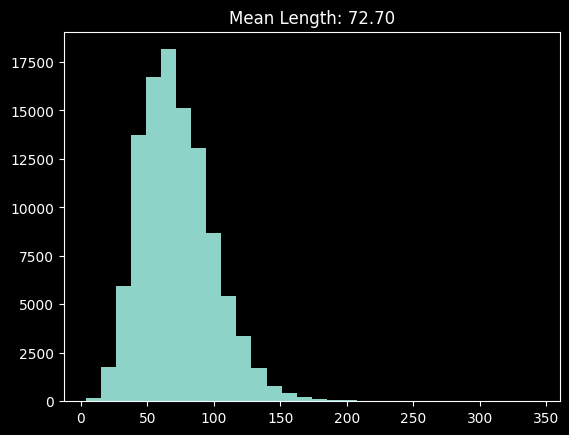

Text(0.5, 1.0, 'Mean Length: 918.41')

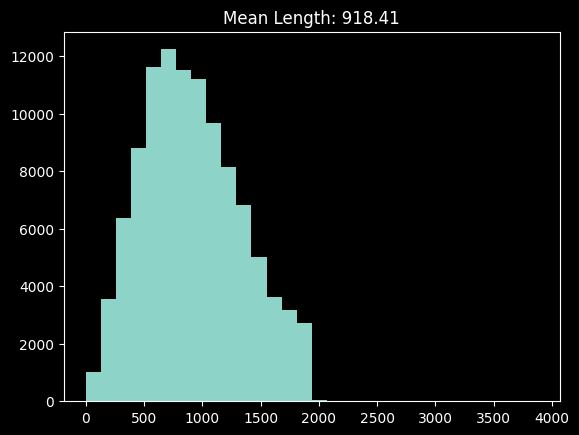

In [7]:
title_lengths = [len(sent) for sent in df["title"].values]
abs_lengths = [len(sent) for sent in df["abstract"].values]

plt.hist(title_lengths, bins=30)
plt.title(f"Mean Length: {np.mean(title_lengths):.2f}")
plt.show()
plt.hist(abs_lengths, bins=30)
plt.title(f"Mean Length: {np.mean(abs_lengths):.2f}")

## Prompt Template

In [8]:
class PaperDataset:
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'abstract': (self.data[idx]['abstract']).strip(),
            'title': self.data[idx]['title'].strip()
        }

In [9]:
def collate_fn(data):
    inputs, outputs = [], []

    for x in data:
        inp = f"### Imagine yourself as a scientist who needs to come up with a title for an article. \
Your task is with known abstract of paper create possible title of it. Abstract: {x['abstract']}\n\n### Title: "
        input_ids = tokenizer(
            inp,
            add_special_tokens=True
        )['input_ids']
        label_ids = tokenizer(
            x['title'] + tokenizer.eos_token,
            add_special_tokens=False,
            max_length=512,
            truncation=True
        )['input_ids']
        inputs.append(torch.tensor(input_ids + label_ids))
        outputs.append(torch.tensor([-100] * len(input_ids) + label_ids))
        
    input_ids = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(outputs, batch_first=True, padding_value=-100)
        
    return {
        'input_ids': input_ids,
        'labels': labels,
        'attention_mask': input_ids.ne(0)
    }

In [10]:
data_files = {"train": "train_new.csv", "val": "val_new.csv"}
data = load_dataset("csv", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

In [11]:
data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'abstract', 'title'],
        num_rows: 103490
    })
    val: Dataset({
        features: ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'abstract', 'title'],
        num_rows: 2113
    })
})

In [12]:
# 1200 models for current task should be enough for finetuning
train_dataset = PaperDataset([data['train'][i] for i in range(int(0.2*len(data['train'])))])
eval_dataset = PaperDataset([data['val'][i] for i in range(300)])

# Metrics

In [13]:
import evaluate
import nltk

metric = evaluate.load('rouge')

def rouge_bleu_custom(pred):
    references = pred.label_ids
    predictions = pred.predictions[0]

    ref_sent = []
    pred_sent = []
    macro_bleu = 0

    for ref, predicted in zip(references, predictions):
        # replace -100 with pad token
        ref[ref == -100] = tokenizer.eos_token_id
        ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
        predicted[predicted == -100] = tokenizer.eos_token_id
        predicted_decoded = tokenizer.decode(predicted, skip_special_tokens=True)
        sequence_start = ref_decoded.find("### Title: ") + 11
        ref_sent.append(ref_decoded[sequence_start:])
        pred_sent.append(predicted_decoded[sequence_start:])
        
        bleu_score = nltk.translate.bleu_score.sentence_bleu(
                [ref_decoded[sequence_start:]],
                predicted_decoded[sequence_start:],
                weights = [0.334, 0.333, 0.333]
        )
        macro_bleu += bleu_score
    metrics_dict = metric.compute(predictions=pred_sent, references=ref_sent)
    metrics_dict['bleu'] = macro_bleu / len(references)
    return metrics_dict

In [14]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak. 
    This is a workaround to avoid storing too many tensors that are not needed.
    """

    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

## Training (messed up with metrics) 

In [15]:
training_args = transformers.TrainingArguments(
        per_device_train_batch_size=5,
        per_device_eval_batch_size=5,
        eval_accumulation_steps=40,
        gradient_accumulation_steps=4,
        num_train_epochs=1,
        learning_rate=2e-4,
        fp16=True,
        save_total_limit=3,
        logging_strategy='steps',
        logging_steps=2,
        output_dir="experiments",
        optim="paged_adamw_8bit",
        lr_scheduler_type="cosine",
        warmup_ratio=0.05,
        logging_dir = './logs',
        report_to = 'tensorboard',
        evaluation_strategy ='steps',
        eval_steps=250,
        save_strategy='steps',
        save_steps=500,
        seed=42,
        remove_unused_columns=False,
        load_best_model_at_end=True,
)

trainer = transformers.Trainer(
    model,
    training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    compute_metrics=rouge_bleu_custom,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=Tru

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu
250,1.640500,1.527030,0.076244,0.034130,0.067723,0.069258,0.059714
500,1.553200,1.513356,0.076971,0.035088,0.068752,0.068784,0.059747
750,1.577800,1.502270,0.075977,0.034294,0.067567,0.067742,0.059814
1000,1.355300,1.500344,0.076308,0.034704,0.068015,0.068164,0.059873


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended th

TrainOutput(global_step=1035, training_loss=1.570867759824375, metrics={'train_runtime': 11125.6509, 'train_samples_per_second': 1.86, 'train_steps_per_second': 0.093, 'total_flos': 2.8631079596007552e+17, 'train_loss': 1.570867759824375, 'epoch': 1.0})

## Load checkpoint and test model

In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
  
# using the style for the plot 
plt.style.use('dark_background') 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [3]:
PEFT_MODEL = "checkpoint-1000"

config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
model = PeftModel.from_pretrained(model, PEFT_MODEL)

In [5]:
# Параметры для генерации
generation_params = {
    "max_new_tokens": 150,
    "num_beams": 2,
    "early_stopping": True,
    "no_repeat_ngram_size": 2,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.eos_token_id,
}

In [6]:
import numpy as np

In [7]:
data_files = {"train": "train_new.csv", "val": "val_new.csv"}
data = load_dataset("csv", data_files=data_files)

In [8]:
i = np.random.randint(1350)
prompt = f"### Imagine yourself as a scientist who needs to come up with a title for an article. \
Your task is with known abstract of paper create possible title of it. Abstract: {data['val'][i]['abstract']}\n\n### Title: "

device = "cuda:0"
encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids = encoding.input_ids,
        attention_mask = encoding.attention_mask,
        **generation_params,
    )
pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
sequence_start = pred_text.find("### Title: ") + 11
print("LLM Output: " + pred_text[sequence_start:])
print("---------------------------------")
print("Validation Output: " + data['val'][i]['title'])

LLM Output: nuclear black hole and its host galaxy
---------------------------------
Validation Output: towards a comprehensive fueling-controlled theory on the growth of   massive black holes and host spheroids


In [9]:
val_answers = []
for abstract_str in tqdm(data["val"]["abstract"][:60]):
    prompt = f"### Imagine yourself as a scientist who needs to come up with a title for an article. \
Your task is with known abstract of paper create possible title of it. Abstract: {abstract_str}\n\n### Title: "

    device = "cuda:0"
    encoding = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids = encoding.input_ids,
            attention_mask = encoding.attention_mask,
            **generation_params,
        )

    gen_title = tokenizer.decode(outputs[0], skip_special_tokens=True)
    sequence_start = gen_title.find("### Title: ") + 11
    title_processed = gen_title[sequence_start:]
    val_answers.append(title_processed)

100%|██████████| 60/60 [03:25<00:00,  3.43s/it]


In [10]:
macro_bleu = 0
n_gram_weights = [0.333, 0.334, 0.333]
for i, abstract_str in tqdm(enumerate(data["val"]["abstract"][:60])):
    gen = val_answers[i]
    ori = data["val"]["title"][i]
    print(f'Оригинальный заголовок: {ori}')
    print(f'Предсказанный заголовок: {gen}')
    print('-----------------------------------')

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
            [ori],
            gen,
            weights = n_gram_weights
        )   
    macro_bleu += bleu_score
print(f"Maccro Bleu: {macro_bleu / 60.:4f}")

60it [00:00, 790.51it/s]

Оригинальный заголовок: invariance times
Предсказанный заголовок: invariance of martingales
-----------------------------------
Оригинальный заголовок: a distance-based test of association between paired heterogeneous   genomic data
Предсказанный заголовок: the generalized r-value test: a statistical method for detecting   shared variability across heterogeneous biological data
-----------------------------------
Оригинальный заголовок: how many paths to simulate correlated brownian motions?
Предсказанный заголовок: the optimal path length for the simulation of correlated bm's
-----------------------------------
Оригинальный заголовок: the international linear collider
Предсказанный заголовок: international linear accelerator for colliders
-----------------------------------
Оригинальный заголовок: the open connectome project data cluster: scalable analysis and vision   for high-throughput neuroscience
Предсказанный заголовок: scalable data management for brain connectome analysis
----